In [1]:
%load_ext autoreload
%autoreload 2

In [112]:
import numpy as np
import open3d as o3d
from datetime import datetime

from utils import *
from bpy_utils import get_manus_data, get_fbx_creation_time

import sys
manopth_dir = 'C:/Users/lucas/Desktop/UPC/MIT/manopth/'
sys.path.insert(1, manopth_dir)

from manus.utils import Pressure

In [3]:

recording_dir = "C:/Users/lucas/Desktop/UPC/MIT/tactile2object/intrinsics_extrinsics/data/20210722/round_3_fixed_bottle_pose_1/"
recording_dir = "C:/Users/lucas/Desktop/UPC/MIT/tactile2object/intrinsics_extrinsics/data/20210722/round_2_fixed_wooden_cube/"

for name in os.listdir(recording_dir):
    name_pth = os.path.join(recording_dir, name)
    
    if os.path.isdir(name_pth):
        print("recording:", name)
        cameras_dir = name_pth
        
    elif ".hdf5" in name:
        print("pressure_file:", name)
        perssure_pth = name_pth
        
    elif ".fbx" in name:
        print("manus_file:", name)
        manus_pth = name_pth
        
#cameras_dir = os.path.join(recording_dir, "20210722_152500")
#perssure_pth = os.path.join(recording_dir, ".hdf5")
#manus_pth = os.path.join(recording_dir, ".fbx")

pressure_file: 07222021_2.hdf5
recording: 20210722_152500
manus_file: recording_2021-07-22_14-26-10.fbx


# Load data

### Camera data

In [4]:
cameras = ["020122061233", "821312060044", "020122061651", "821312062243"]

intrinsics = Intrinsics(cameras_dir)
extrinsics = Extrinsics(cameras_dir)
rgbds = RGBD(cameras_dir)
stitched_pcd = Stitching_pcds(intrinsics, extrinsics, rgbds, cameras)
apriltags = AprilTags(cameras_dir, intrinsics, extrinsics, cameras=cameras)
stitched_pcd = Stitching_pcds(intrinsics, extrinsics, rgbds, cameras)

### Pressure data

In [123]:
pressure = Pressure(perssure_pth, lim_low=3, lim_high=50)

### Manus data

Takes around two minutes to load the manus data and compute the MANO joints and verts

In [ ]:
%%capture

hand_verts, hand_joints = get_manus_data(manus_pth, manopth_dir)

# Synchronize

In [ ]:
cameras_dir

In [9]:
# Camera timestamps
ts_camera = get_camera_timestamps(cameras_dir)

# Pressure timestamps
ts_pressure = pressure.ts_touch

# MANUS timestamp
pyfbx_i42_pth = "C:/Users/lucas/Desktop/UPC/MIT/pyfbx_i42-master/"
ts_manus = get_fbx_creation_time(manus_pth, pyfbx_i42_pth)

In [10]:
datetime.fromtimestamp(ts_manus)

datetime.datetime(2021, 7, 22, 16, 26, 10, 997000)

In [72]:
class Synchronizer:
    def __init__(self, ts_pressure, ts_camera):
        self.ts_pressure = ts_pressure
        offset = ts_camera[0] - ts_pressure[0]
        self.ts_camera = ts_camera - offset
        
    def pressure_to_camera(self, frame_p):
        ts_p = self.ts_pressure[frame_p]
        frame_c = (np.abs(self.ts_camera - ts_p)).argmin()
        return frame_c
    
    def camera_to_pressure(self, frame_c):
        ts_c = self.ts_camera[frame_c]
        frame_p = (np.abs(self.ts_pressure - ts_c)).argmin()
        return frame_p 

In [73]:
synchronize = Synchronizer(ts_pressure, ts_camera)

# Save tactile img

In [77]:
tactile_dir = os.path.join(apriltags.cameras_dir, "imgs", "pressure_img")

if not os.path.exists(tactile_dir):
    os.makedirs(tactile_dir)

for frame_c in range(len(ts_camera)):
    frame_p = synchronize.camera_to_pressure(frame_c)
    
    fig = pressure.get_figure(frame_p, show=False)
    img_pth = os.path.join(tactile_dir, f"img_{frame_c}")
    fig.savefig(img_pth)

# Find offset

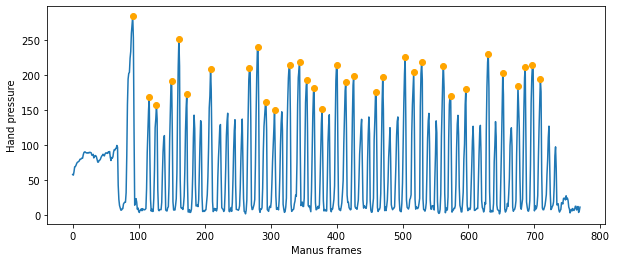

In [129]:
pressure.plot_peaks()